In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

In [ ]:
!mkdir dataset

mkdir: cannot create directory ‘dataset’: File exists


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Get the dataset
!unzip /content/drive/MyDrive/UnetModels/classification/balanced_dataset.zip -d /content/dataset

Archive:  /content/drive/MyDrive/UnetModels/classification/balanced_dataset.zip
replace /content/dataset/Normal/Normal (1868).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace /content/dataset/Normal/Normal (1044).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace /content/dataset/Normal/Normal (3183).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
#Load the model here
from keras.models import load_model
model = load_model('/content/drive/MyDrive/FinalUnet.h5',compile=False)

Preprocessed image shape: (1, 512, 512, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


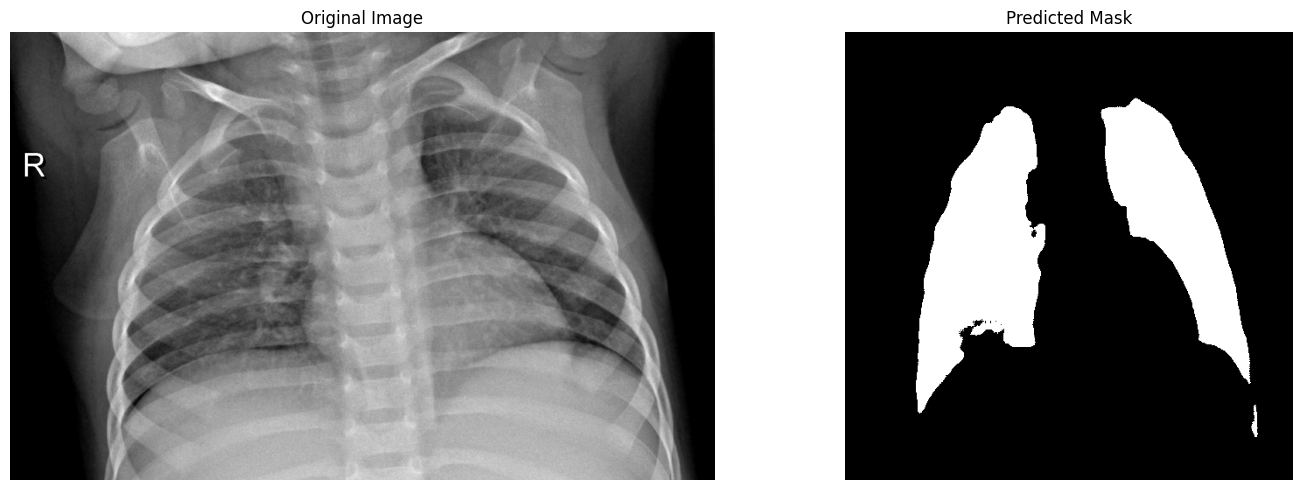

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_and_preprocess_image(image_path, image_size=(512, 512)):
    # Load the grayscale image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image could not be loaded: {image_path}")

    # Resize the image to match model input and normalize
    img_resized = cv2.resize(img, image_size) / 255.0
    img_resized = np.stack([img_resized] * 3, axis=-1)  # Expand to 3 channels
    return img, img_resized  # Return original and resized images

# Image path
image_path = "/content/dataset/Normal/Normal (1010).jpg"

# Load and preprocess the image
original_image, preprocessed_image = load_and_preprocess_image(image_path)

# Add a batch dimension for model prediction
preprocessed_image_batch = np.expand_dims(preprocessed_image, axis=0)
print(f"Preprocessed image shape: {preprocessed_image_batch.shape}")

# Make prediction
predicted_mask = model.predict(preprocessed_image_batch)

# Ensure the predicted mask is binary
predicted_mask_binary = (predicted_mask > 0.5).astype(np.uint8)

# Plot Original Image and Predicted Mask
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(predicted_mask_binary[0, :, :, 0], cmap='gray')
axes[1].set_title('Predicted Mask')
axes[1].axis('off')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


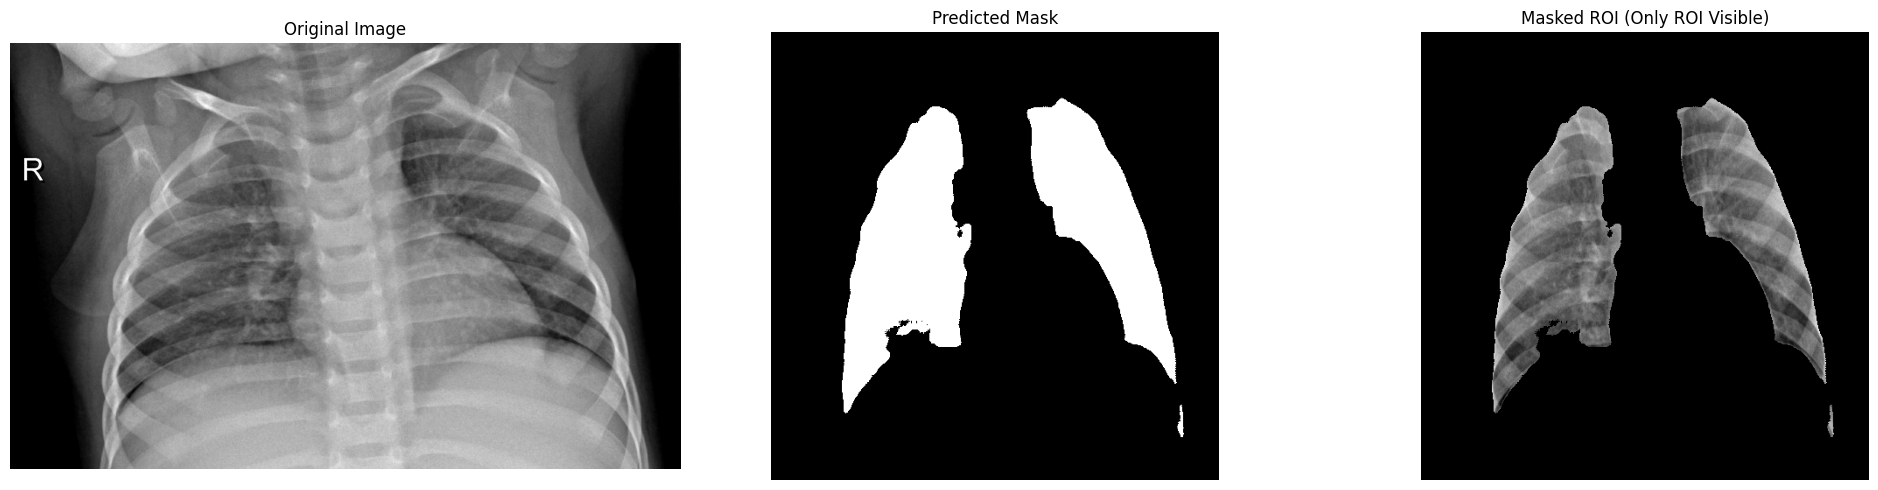

In [ ]:
def load_and_preprocess_image(image_path, image_size=(512, 512)):
    # Check if the image exists
    if not os.path.exists(image_path):
        raise ValueError(f"Image not found: {image_path}")

    # Load the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image could not be loaded: {image_path}")

    # Resize the image and normalize
    img_resized = cv2.resize(img, image_size) / 255.0
    img_resized = np.expand_dims(img_resized, axis=-1)  # Add channel dimension for grayscale

    # Convert to 3 channels if your model expects (512, 512, 3)
    img_resized = np.repeat(img_resized, 3, axis=-1)
    return img, img_resized

def extract_roi_mask(original_image, binary_mask, image_size=(512, 512)):
    # Resize original image to match binary_mask shape
    original_image_resized = cv2.resize(original_image, image_size)

    # Ensure binary mask is binary (0 and 1) for masking
    binary_mask = binary_mask.astype(np.uint8)

    # Mask the resized original image to show only the ROI
    roi_masked = original_image_resized * binary_mask

    return roi_masked

# Set the path to your test image
image_path = '/content/dataset/Normal/Normal (1010).jpg'

# Load and preprocess the image
original_image, preprocessed_image = load_and_preprocess_image(image_path)

# Add a batch dimension for prediction
preprocessed_image_batch = np.expand_dims(preprocessed_image, axis=0)

# Make prediction and binarize mask
predicted_mask = model.predict(preprocessed_image_batch)
predicted_mask_binary = (predicted_mask > 0.5).astype(np.uint8)

# Apply binary mask to resized original image to keep only ROI
roi_masked_image = extract_roi_mask(original_image, predicted_mask_binary[0, :, :, 0])

# Display the Original Image, Predicted Mask, and Masked ROI
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(predicted_mask_binary[0, :, :, 0], cmap='gray')
axes[1].set_title('Predicted Mask')
axes[1].axis('off')

axes[2].imshow(roi_masked_image, cmap='gray')
axes[2].set_title('Masked ROI (Only ROI Visible)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

Use this function from here onwards

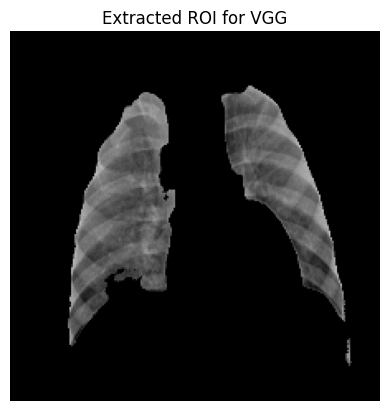

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def extract_roi_from_mask(original_image, predicted_mask_binary, target_size=(224, 224)):
    # Ensure binary mask is scaled to match 8-bit image intensity (0-255)
    if predicted_mask_binary.max() <= 1:
        predicted_mask_binary = (predicted_mask_binary * 255).astype(np.uint8)

    # Resize the original image to match the mask dimensions if they differ
    if original_image.shape != predicted_mask_binary.shape:
        original_image = cv2.resize(original_image, (predicted_mask_binary.shape[1], predicted_mask_binary.shape[0]))

    # Apply the binary mask to the original image
    roi = cv2.bitwise_and(original_image, original_image, mask=predicted_mask_binary)

    # Resize ROI to VGG input size (224, 224)
    roi_resized = cv2.resize(roi, target_size)

    # Convert to 3-channel format for VGG input
    roi_resized_3ch = np.stack([roi_resized] * 3, axis=-1)

    return roi_resized_3ch

# Example usage
roi_image = extract_roi_from_mask(original_image, predicted_mask_binary[0, :, :, 0])

# Display the ROI image
plt.imshow(roi_image)
plt.title("Extracted ROI for VGG")
plt.axis('off')
plt.show()

**BUILDING THE CLASSFIER**

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
import tensorflow as tf

def build_vgg_classifier(input_shape=(224, 224, 3), num_classes=3):
    # Load the pre-trained VGG16 model + higher level layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the layers of VGG16 to avoid training them
    for layer in base_model.layers:
        layer.trainable = False

    # Custom layers for our classification task
    x = Flatten()(base_model.output)
    x = Dense(512, activation='relu')(x)  # Increased to 512 for added feature capacity
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)  # Softmax for multi-class classification

    # Combine base model and custom layers
    model = Model(inputs=base_model.input, outputs=output)

    return model

# Build the model
vgg_model = build_vgg_classifier()

# Compile the model with a lower learning rate for better stability
vgg_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Set custom learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary of the model to confirm structure
vgg_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 27,561,795 (105.14 MB)

 Trainable params: 12,847,107 (49.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

PrePare Dataset

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
import os
import numpy as np
import cv2
import gc
import tensorflow as tf

# Define paths
input_dir = "/content/dataset"
output_dir = "/content/roi_dataset"

# Create output directories if they don't exist
os.makedirs(output_dir, exist_ok=True)
class_dirs = ["Pneumonia-Viral","Normal","Pneumonia-Bacterial"]
for cls in class_dirs:
    os.makedirs(os.path.join(output_dir, cls), exist_ok=True)

# Function to load and preprocess the image
def load_and_preprocess_image(image_path, image_size=(512, 512)):
    img = cv2.imread(image_path)  # Load as RGB
    img_resized = cv2.resize(img, image_size) / 255.0  # Resize to match the model input
    return img_resized  # Return the resized image without wavelet transformation

# Function to batch-process images and save segmentation masks as ROIs
def process_images_in_batches(input_class_dir, output_class_dir, model, batch_size=1):
    images = [img for img in os.listdir(input_class_dir) if os.path.isfile(os.path.join(input_class_dir, img))]
    num_batches = len(images) // batch_size + (1 if len(images) % batch_size != 0 else 0)

    for batch_num in range(num_batches):
        batch_images = images[batch_num * batch_size: (batch_num + 1) * batch_size]
        original_images = []
        preprocessed_images = []

        # Load and preprocess batch images
        for img_name in batch_images:
            img_path = os.path.join(input_class_dir, img_name)
            original_image = load_and_preprocess_image(img_path)
            original_images.append(original_image)
            preprocessed_images.append(original_image)  # Use the same resized image for prediction

        # Convert batch to numpy array for prediction
        preprocessed_image_batch = np.array(preprocessed_images)

        # Predict the masks
        predicted_masks = model.predict(preprocessed_image_batch)
        predicted_masks_binary = (predicted_masks > 0.5).astype(np.uint8)

        # Process each mask in the batch and save ROI
        for i, img_name in enumerate(batch_images):
            # Only process if the mask has ROI
            if np.max(predicted_masks_binary[i]) == 0:
                print(f"No ROI detected for {img_name}. Skipping...")
                continue

            # Resize the predicted mask to match the original image size
            original_image_shape = original_images[i].shape[:2]
            predicted_mask_resized = cv2.resize(predicted_masks_binary[i, :, :, 0], (original_image_shape[1], original_image_shape[0]))

            # Extract ROI
            roi_image = original_images[i] * predicted_mask_resized[:, :, np.newaxis]  # Expand dimensions of the mask
            roi_image_uint8 = (roi_image * 255).astype(np.uint8)

            # Save the ROI image
            output_path = os.path.join(output_class_dir, img_name)
            cv2.imwrite(output_path, roi_image_uint8)
            print(f"Saved ROI to: {output_path}")

        # Free memory after each batch
        del original_images, preprocessed_images, preprocessed_image_batch, predicted_masks, predicted_masks_binary
        gc.collect()

# Run the function for each class directory
for cls in class_dirs:
    input_class_dir = os.path.join(input_dir, cls)
    output_class_dir = os.path.join(output_dir, cls)
    process_images_in_batches(input_class_dir, output_class_dir, model, batch_size=16)
    #tf.keras.backend.clear_session()

print("ROI extraction and saving complete!")

Streaming output truncated to the last 5000 lines.
Saved ROI to: /content/roi_dataset/Pneumonia-Viral/Pneumonia-Viral (984).jpg
Saved ROI to: /content/roi_dataset/Pneumonia-Viral/Pneumonia-Viral (64).jpg
Saved ROI to: /content/roi_dataset/Pneumonia-Viral/Pneumonia-Viral (336).jpg
Saved ROI to: /content/roi_dataset/Pneumonia-Viral/Pneumonia-Viral (1151).jpg
Saved ROI to: /content/roi_dataset/Pneumonia-Viral/Pneumonia-Viral (965).jpg
Saved ROI to: /content/roi_dataset/Pneumonia-Viral/Pneumonia-Viral (10).jpg
Saved ROI to: /content/roi_dataset/Pneumonia-Viral/Pneumonia-Viral (121).jpg
Saved ROI to: /content/roi_dataset/Pneumonia-Viral/Pneumonia-Viral (1164).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Saved ROI to: /content/roi_dataset/Pneumonia-Viral/Pneumonia-Viral (329).jpg
Saved ROI to: /content/roi_dataset/Pneumonia-Viral/Pneumonia-Viral (1350).jpg
Saved ROI to: /content/roi_dataset/Pneumonia-Viral/Pneumonia-Viral (524).jpg
Saved ROI to: /content/roi_dataset/Pneumonia-Viral/Pneumonia-Vi

In [ ]:
# import shutil

# folder_to_delete = "/content/roi_dataset"  # Replace with the actual folder name

# try:
#     shutil.rmtree(folder_to_delete)
#     print(f"Folder '{folder_to_delete}' deleted successfully.")
# except FileNotFoundError:
#     print(f"Folder '{folder_to_delete}' not found.")
# except OSError as e:
#     print(f"Error deleting folder '{folder_to_delete}': {e}")

Folder '/content/roi_dataset' deleted successfully.


In [ ]:
!zip -r /content/NormalUnet_roi_dataset.zip /content/roi_dataset
from google.colab import files
files.download("/content/NormalUnet_roi_dataset.zip")

  adding: content/roi_dataset/ (stored 0%)
  adding: content/roi_dataset/Normal/ (stored 0%)
  adding: content/roi_dataset/Normal/Normal (2562).jpg (deflated 9%)
  adding: content/roi_dataset/Normal/Normal (778).jpg (deflated 9%)
  adding: content/roi_dataset/Normal/Normal (917).jpg (deflated 8%)
  adding: content/roi_dataset/Normal/Normal (1451).jpg (deflated 6%)
  adding: content/roi_dataset/Normal/Normal (3230).jpg (deflated 7%)
  adding: content/roi_dataset/Normal/Normal (2443).jpg (deflated 9%)
  adding: content/roi_dataset/Normal/Normal (966).jpg (deflated 12%)
  adding: content/roi_dataset/Normal/Normal (566).jpg (deflated 8%)
  adding: content/roi_dataset/Normal/Normal (14).jpg (deflated 11%)
  adding: content/roi_dataset/Normal/Normal (1011).jpg (deflated 10%)
  adding: content/roi_dataset/Normal/Normal (1505).jpg (deflated 8%)
  adding: content/roi_dataset/Normal/Normal (2138).jpg (deflated 6%)
  adding: content/roi_dataset/Normal/Normal (726).jpg (deflated 12%)
  adding: con

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Test Train Val Split 80 10 10

In [ ]:
import os
import shutil
import random

# Define paths
roi_dir = "/content/roi_dataset"  # Original ROI dataset directory
output_base_dir = "/content/split_roi_dataset"  # Output directory for split data

# Define the split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Ensure output directories exist
splits = ['train', 'val', 'test']
class_dirs = ["Normal", "Pneumonia-Viral", "Pneumonia-Bacterial"]

for split in splits:
    for cls in class_dirs:
        os.makedirs(os.path.join(output_base_dir, split, cls), exist_ok=True)

# Split and move files
for cls in class_dirs:
    class_path = os.path.join(roi_dir, cls)
    images = os.listdir(class_path)
    random.shuffle(images)

    # Calculate split indices
    train_count = int(train_ratio * len(images))
    val_count = int(val_ratio * len(images))

    # Assign images to each set
    train_images = images[:train_count]
    val_images = images[train_count:train_count + val_count]
    test_images = images[train_count + val_count:]

    # Move images to respective directories
    for img_list, split in zip([train_images, val_images, test_images], splits):
        for img_name in img_list:
            src = os.path.join(class_path, img_name)
            dest = os.path.join(output_base_dir, split, cls, img_name)
            shutil.copy2(src, dest)  # Copy file to new split folder

    print(f"Completed split for class '{cls}'")

print("Dataset split complete!")

Completed split for class 'Normal'
Completed split for class 'Pneumonia-Viral'
Completed split for class 'Pneumonia-Bacterial'
Dataset split complete!


In [ ]:
# prompt: code to check the number of images in a folder

import os

def count_images_in_folder(folder_path):
  """Counts the number of image files in a given folder.

  Args:
    folder_path: The path to the folder containing the images.

  Returns:
    The number of image files in the folder.
  """
  image_extensions = ('.jpg', '.jpeg', '.png', '.gif', '.bmp')  # Add more if needed
  image_count = 0
  for filename in os.listdir(folder_path):
    if filename.lower().endswith(image_extensions):
      image_count += 1
  return image_count

folder_path = "/content/split_roi_dataset/test/Normal"  # Replace with your folder path
num_images = count_images_in_folder(folder_path)
print(f"The number of images in '{folder_path}' is: {num_images}")

folder_path = "/content/split_roi_dataset/train/Normal"  # Replace with your folder path
num_images = count_images_in_folder(folder_path)
print(f"The number of images in '{folder_path}' is: {num_images}")

folder_path = "/content/split_roi_dataset/val/Normal"  # Replace with your folder path
num_images = count_images_in_folder(folder_path)
print(f"The number of images in '{folder_path}' is: {num_images}")

folder_path = "/content/roi_dataset/Normal"  # Replace with your folder path
num_images = count_images_in_folder(folder_path)
print(f"The number of images in '{folder_path}' is: {num_images}")

The number of images in '/content/split_roi_dataset/test/Normal' is: 167
The number of images in '/content/split_roi_dataset/train/Normal' is: 1324
The number of images in '/content/split_roi_dataset/val/Normal' is: 165
The number of images in '/content/roi_dataset/Normal' is: 1656


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Paths for train, validation, and test sets
train_dir = "/content/split_roi_dataset/train"
val_dir = "/content/split_roi_dataset/val"
test_dir = "/content/split_roi_dataset/test"

# Image Data Generators for training, validation, and test sets
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
val_test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 3966 images belonging to 3 classes.
Found 494 images belonging to 3 classes.
Found 499 images belonging to 3 classes.


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint('vgg_model_best.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

epochs = 50
history = vgg_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=epochs,
    callbacks=[checkpoint, early_stopping]
)

print("Training complete!")

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.5048 - loss: 1.1029
Epoch 1: val_loss improved from inf to 0.63306, saving model to vgg_model_best.keras
123/123 ━━━━━━━━━━━━━━━━━━━━ 90s 582ms/step - accuracy: 0.5054 - loss: 1.1014 - val_accuracy: 0.7229 - val_loss: 0.6331
Epoch 2/50
  1/123 ━━━━━━━━━━━━━━━━━━━━ 20s 164ms/step - accuracy: 0.6562 - loss: 0.7556

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 0.63306 to 0.46316, saving model to vgg_model_best.keras
123/123 ━━━━━━━━━━━━━━━━━━━━ 15s 120ms/step - accuracy: 0.6562 - loss: 0.7556 - val_accuracy: 0.8571 - val_loss: 0.4632
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.6506 - loss: 0.7495
Epoch 3: val_loss did not improve from 0.46316
123/123 ━━━━━━━━━━━━━━━━━━━━ 54s 419ms/step - accuracy: 0.6506 - loss: 0.7494 - val_accuracy: 0.7000 - val_loss: 0.6177
Epoch 4/50
  1/123 ━━━━━━━━━━━━━━━━━━━━ 14s 118ms/step - accuracy: 0.6562 - loss: 0.7046
Epoch 4: val_loss did not improve from 0.46316
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - accuracy: 0.6562 - loss: 0.7046 - val_accuracy: 0.8571 - val_loss: 0.6379
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.6602 - loss: 0.7121
Epoch 5: val_loss did not improve from 0.46316
123/123 ━━━━━━━━━━━━━━━━━━━━ 82s 421ms/step - accuracy: 0.6602 - loss: 0.7121 - val_accuracy: 0.7458 - val_loss: 0.5754
Epoch 6/50
  1/123 ━━━━━━

In [ ]:
test_loss, test_acc = vgg_model.evaluate(test_generator, steps=test_generator.samples)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

499/499 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.7154 - loss: 0.5732  
Test Accuracy: 71.54%


MobileNet Classification

In [ ]:
from keras import backend as K
K.clear_session()

In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

def build_mobilenet_classifier(input_shape=(224, 224, 3), num_classes=3):
    # Load the pre-trained MobileNet model
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the layers of MobileNet
    for layer in base_model.layers:
        layer.trainable = False

    # Custom layers for our classification task
    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)  # Softmax for multi-class classification

    # Combine base model and custom layers
    model = Model(inputs=base_model.input, outputs=output)

    return model

# Build the model
mobilenet_model = build_mobilenet_classifier()

# Compile the model with relevant metrics
mobilenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Image data generators for training and validation
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 3966 images belonging to 3 classes.
Found 494 images belonging to 3 classes.
Found 499 images belonging to 3 classes.


In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
mobilenet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 26s 146ms/step - accuracy: 0.5737 - loss: 11.0086 - val_accuracy: 0.7271 - val_loss: 0.5775
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7500 - loss: 0.6499 - val_accuracy: 0.7857 - val_loss: 0.6660
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - accuracy: 0.6941 - loss: 0.6406 - val_accuracy: 0.7312 - val_loss: 0.5520
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step - accuracy: 0.5625 - loss: 0.5624 - val_accuracy: 0.7857 - val_loss: 0.5772
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - accuracy: 0.6913 - loss: 0.6395 - val_accuracy: 0.7833 - val_loss: 0.5277
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step - accuracy: 0.7500 - loss: 0.4771 - val_accuracy: 0.4286 - val_loss: 0.8615
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.7028 - loss: 0.5815 - val_accuracy: 0.7937 - val_loss: 0.4990
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step - accuracy: 0.8125 - loss: 0.5153 -

In [ ]:
test_loss, test_acc = mobilenet_model.evaluate(test_generator, steps=test_generator.samples)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

499/499 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7721 - loss: 0.5787    
Test Accuracy: 77.15%


ResNet Classification:

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout

def build_resnet_classifier(input_shape=(224, 224, 3), num_classes=3):
    # Load the pre-trained ResNet50 model + higher level layers
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the layers of ResNet50 to avoid training them
    for layer in base_model.layers:
        layer.trainable = False

    # Custom layers for our classification task
    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)  # Softmax for multi-class classification

    # Combine base model and custom layers
    model = Model(inputs=base_model.input, outputs=output)

    return model

# Build the model
resnet_model = build_resnet_classifier()

# Compile the model with relevant metrics
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
resnet_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 49,278,851 (187.98 MB)

 Trainable params: 25,691,139 (98.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('resnet_model.keras', save_best_only=True)
]

history = resnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 51s 303ms/step - accuracy: 0.3765 - loss: 4.3082 - val_accuracy: 0.5870 - val_loss: 1.0252
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 23s 178ms/step - accuracy: 0.4663 - loss: 1.0302 - val_accuracy: 0.6437 - val_loss: 0.9339
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 15s 113ms/step - accuracy: 0.4565 - loss: 1.0115 - val_accuracy: 0.5466 - val_loss: 1.0042
Epoch 4/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 77s 622ms/step - accuracy: 0.4625 - loss: 1.0079 - val_accuracy: 0.6134 - val_loss: 0.8887
Epoch 5/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - accuracy: 0.4742 - loss: 0.9969 - val_accuracy: 0.6336 - val_loss: 0.8893
Epoch 6/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 62s 503ms/step - accuracy: 0.4743 - loss: 0.9820 - val_accuracy: 0.6457 - val_loss: 0.8399
Epoch 7/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 33s 107ms/step - accuracy: 0.4430 - loss: 1.0184 - val_accuracy: 0.3340 - val_loss: 1.1142
Epoch 8/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 21s 109ms/step - accuracy: 0.3343 - loss: 1

In [ ]:
test_loss, test_acc = resnet_model.evaluate(test_generator, steps=test_generator.samples)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

EffecientNet Classifer

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Build the EfficientNet model
def build_efficientnet_classifier(input_shape=(224, 224, 3), num_classes=3):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in base_model.layers:
        layer.trainable = False

    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model

# Build and compile the model
efficientnet_model = build_efficientnet_classifier()
efficientnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('efficientnet_model.keras', save_best_only=True)
]

history = efficientnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=callbacks
)

In [ ]:
test_loss, test_acc = efficientnet_model.evaluate(test_generator, steps=test_generator.samples)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Xception Classifer

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Build the Xception model
def build_xception_classifier(input_shape=(224, 224, 3), num_classes=3):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in base_model.layers:
        layer.trainable = False

    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model

# Build and compile the model
xception_model = build_xception_classifier()
xception_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Set up callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('xception_model.keras', save_best_only=True)
]

# Train the model
history = xception_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=callbacks
)

In [ ]:
test_loss, test_acc = xception_model.evaluate(test_generator, steps=test_generator.samples)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Uploading Models

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from google.colab import drive
import os

# Define the directory to save models in Google Drive
model_save_path = '/content/drive/MyDrive/UnetModels/classification'
os.makedirs(model_save_path, exist_ok=True)

vgg_model.save(os.path.join(model_save_path, 'vgg_model.h5'))

print("VGG model saved successfully!")

In [ ]:
mobilenet_model.save(os.path.join(model_save_path, 'vgg_model.h5'))

print("MobileNet model saved successfully!")

In [ ]:
effecientnet_model.save(os.path.join(model_save_path, 'vgg_model.h5'))

print("EffecientNet model saved successfully!")

In [ ]:
resnet_model.save(os.path.join(model_save_path, 'vgg_model.h5'))

print("ResNet model saved successfully!")

In [ ]:
xception_model.save(os.path.join(model_save_path, 'vgg_model.h5'))

print("Xception model saved successfully!")

Testing an Image